In [ ]:
!nvidia-smi

Fri Jun  2 08:04:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles')
!pwd

/content
/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles


In [ ]:
!pip install transformers
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import gc

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.classification import Accuracy, ConfusionMatrix, AUROC, Precision, Recall, F1Score
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [ ]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
train_dt = pd.read_csv("Datasets/Splits/Train/FakeNewsTFG_label_lie_train.csv")
test_dt = pd.read_csv("Datasets/Splits/Test/FakeNewsTFG_label_lie_test.csv")

In [ ]:
(train_dt.shape, test_dt.shape)

((17047, 2), (7306, 2))

In [ ]:
(train_dt.head(), test_dt.head())

(                                                text  bluff
 0   Trump Blasted Nordstrom For Dropping Ivanka’s...      1
 1  Pakistan's top diplomat pushes back on U.S. cl...      0
 2  North Korea says more sanctions will spur it t...      0
 3  Senate passes bill to boost travel security af...      0
 4  Despite no evidence, White House says Trump st...      0,
                                                 text  bluff
 0  TUCKER CARLSON EXPOSES REFUGEE CONTRACTOR Who ...      1
 1  Romania negotiating to buy U.S. rocket systems...      0
 2   Judge Who Barred A Mom From Seeing Her Baby F...      1
 3  Pro-Kurdish opposition leader's trial opens in...      0
 4   White Supremacists Robocall For Trump Ahead O...      1)

In [ ]:
train_dt['bluff'].value_counts()

0    9218
1    7829
Name: bluff, dtype: int64

In [ ]:
token_counts = []
for _, row in train_dt.iterrows():
  token_count = len(tokenizer.encode(
    row['text'],
    truncation = True,
    max_length = 512
  ))
  token_counts.append(token_count)

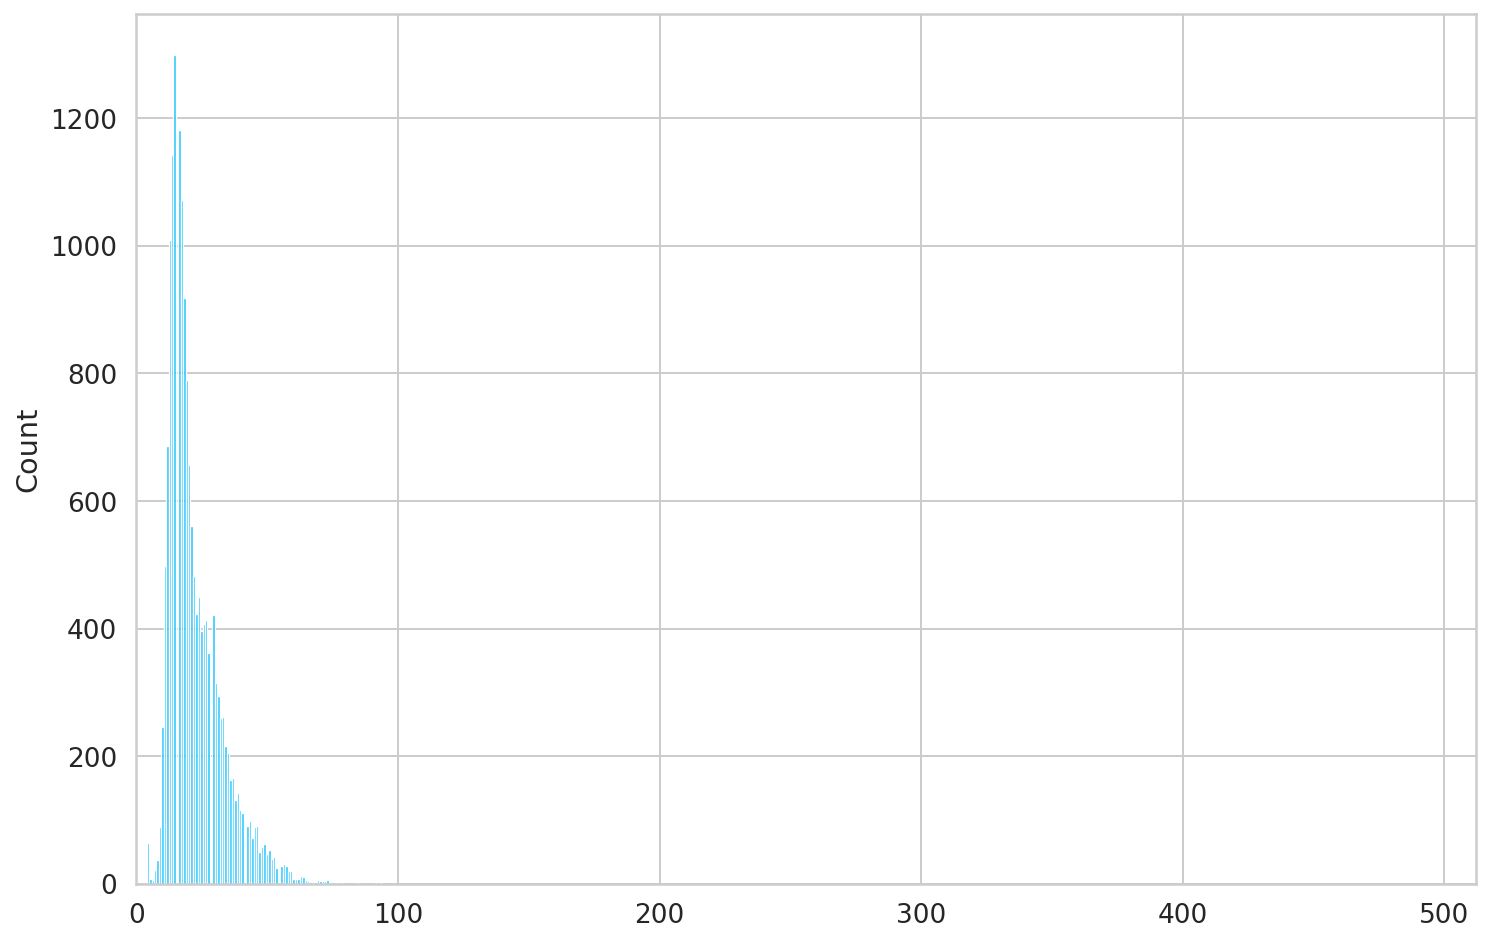

In [ ]:
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [ ]:
max = 0
maxLst = []

for i in token_counts:
  if i > max:
    max = i
    maxLst.append(i)

maxLst
#max_length = 150

[34, 35, 41, 56, 65, 84, 92, 94]

In [ ]:
MAX_TOKEN_COUNT = 150

In [ ]:
TEXT = ['text']
CLASSES = ['bluff']
TARGET = ['bluff']
TASK = "binary"

In [ ]:
N_EPOCHS = 3
BATCH_SIZE = 16

In [ ]:
class DTset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 512
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    text = data_row[TEXT].astype(str).values.tolist()
    classification = data_row[TARGET]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      is_split_into_words = True,
      return_attention_mask=True,
      return_tensors='pt'
    )

    return dict(
      text = text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      classification = torch.FloatTensor(classification)
    )

In [ ]:
class DTModule(pl.LightningDataModule):

  def __init__(self, train_df, val_df, test_df, tokenizer, batch_size = 16, max_token_len = 512):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = DTset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.val_dataset = DTset(
      self.val_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = DTset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.val_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
class BertBasedClassifier(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.sigmoid = nn.Sigmoid()
    self.crossEntropy = nn.BCELoss()
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps

  def forward(self, input_ids, attention_mask, classification=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.out(output.pooler_output)
    output = self.sigmoid(output)
    loss = 0
    if classification is not None:
        loss = self.crossEntropy(output, classification)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    classification = batch["classification"]
    loss, outputs = self(input_ids, attention_mask, classification)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    gc.collect()
    return {"loss": loss, "predictions": outputs, "classification": classification}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    classification = batch["classification"]
    loss, outputs = self(input_ids, attention_mask, classification)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    gc.collect()
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    classification = batch["classification"]
    loss, outputs = self(input_ids, attention_mask, classification)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    gc.collect()
    return loss

  def train_epoch_end(self, outputs):
    predictions = []
    target = []
    for output in outputs:
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
      for out_class in output["classification"].detach().cpu():
        target.append(out_class)
    predictions = torch.stack(predictions)
    target = torch.stack(target).int()
    predictions = torch.from_numpy(np.array(predictions))
    target = torch.from_numpy(np.array(target))
    binary_auroc = AUROC(task=TASK)
    auroc = binary_auroc(predictions, target)
    self.logger.experiment.add_scalar(f"binary_auroc/Train", auroc, self.current_epoch)
    gc.collect()

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

# Fine-tune + Train/Test Evaluation

In [ ]:
(train_dt.shape, test_dt.shape)

((17047, 2), (7306, 2))

In [ ]:
data_module = DTModule(
  train_dt,
  test_dt,
  test_dt,
  tokenizer,
  batch_size = BATCH_SIZE,
  max_token_len = MAX_TOKEN_COUNT
)

In [ ]:
steps_per_epoch=len(train_dt) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(639, 3195)

In [ ]:
model = BertBasedClassifier(
  n_classes= len(CLASSES),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model

BertBasedClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
logger = TensorBoardLogger("Lightning_logs", name="Lexicon-of-Sentences-FakeNewsTFG-logs")

early_stopping_callback = EarlyStopping(monitor='val_loss', patience = 2)

checkpoint_callback = ModelCheckpoint(
  dirpath="Best_model/Lexicon_of_Sentences_FakeNewsTFG",
  filename="Lexicon-of-Sentences-FakeNewsTFG-Best-Checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=N_EPOCHS,
  accelerator="gpu"
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type      | Params
-------------------------------------------
0 | bert         | BertModel | 108 M 
1 | out          | Linear    | 769   
2 | sigmoid      | Sigmoid   | 0     
3 | crossEntropy | BCELoss   | 0     
-------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.244   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1066: 'val_loss' reached 0.03513 (best 0.03513), saving model to '/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles/Best_model/Lexicon_of_Sentences_FakeNewsTFG/Lexicon-of-Sentences-FakeNewsTFG-Best-Checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 2132: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 3198: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
del model
gc.collect()

0

In [ ]:
trained_model = BertBasedClassifier.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(CLASSES)
)
trained_model.eval()
trained_model.freeze()

"""
Load from DIR
trained_model = BertBasedClassifier.load_from_checkpoint(
  "Best_model/Lexicon_of_Sentences_FakeNewsTFG/Lexicon-of-Sentences-FakeNewsTFG-Best-Checkpoint.ckpt",
  n_classes=len(LABELS)
)
trained_model.eval()
trained_model.freeze()
"""

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'\nLoad from DIR\ntrained_model = BertBasedClassifier.load_from_checkpoint(\n  "Best_model/Lexicon_of_Sentences_FakeNewsTFG/Lexicon-of-Sentences-FakeNewsTFG-Best-Checkpoint.ckpt",\n  n_classes=len(LABELS)\n)\ntrained_model.eval()\ntrained_model.freeze()\n'

In [ ]:
trainer.test(trained_model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03513481467962265    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.03513481467962265}]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
test_dataset = DTset(
  test_dt,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
target = []

for item in tqdm(test_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  target.append(item["classification"].int())

predictions = torch.stack(predictions).detach().cpu()
target = torch.stack(target).detach().cpu()

  0%|          | 0/7306 [00:00<?, ?it/s]

In [ ]:
predictions

tensor([[9.9959e-01],
        [3.2343e-04],
        [9.9956e-01],
        ...,
        [4.3583e-04],
        [3.8936e-04],
        [9.9860e-01]])

In [ ]:
target

tensor([[1],
        [0],
        [1],
        ...,
        [0],
        [0],
        [1]], dtype=torch.int32)

In [ ]:
confusionMatrix = ConfusionMatrix(task = TASK, threshold = 0.5)
confusionMatrix(predictions, target)

tensor([[3970,    7],
        [ 160, 3169]])

In [ ]:
accuracy = Accuracy(task = TASK, threshold = 0.5)
print("Accuracy:", accuracy(predictions, target).item())

Accuracy: 0.9771420955657959


In [ ]:
precision = Precision(task = TASK, threshold = 0.5)
recall = Recall(task = TASK, threshold = 0.5)
f1Macro = F1Score(task = TASK, threshold = 0.5)
print("Percision:", precision(predictions, target).item(), "\nRecall:", recall(predictions, target).item(), "\nF1 Score:", f1Macro(predictions, target).item())

Percision: 0.9977959990501404 
Recall: 0.9519374966621399 
F1 Score: 0.9743274450302124


In [ ]:
auroc = AUROC(task = TASK)
print("AUROC:", auroc(predictions, target).item())

AUROC: 0.9990209937095642


In [ ]:
test_dt['bluff'].value_counts()

0    3977
1    3329
Name: bluff, dtype: int64